Some useful links :

https://www.tensorflow.org/tutorials/structured_data/time_series

https://www.datacamp.com/community/tutorials/lstm-python-stock-market

https://medium.com/@randerson112358/predict-stock-prices-using-python-machine-learning-53aa024da20a

1. [Import packages](#1)
1. [Load data](#2)
1. [EDA](#14)
1. [Support Vector Machine](#3)
1. [Linear Regression](#4)
1. [Lasso](#5)
1. [Machine learning models performances](#6)
1. [A quick look at our model's performance](#7)
1. [One-Step Ahead Prediction via Averaging](#8)
1. [Standard Average](#9)
1. [Exponential moving average](#10)
1. [Deep Learning with LSTM](#11)
1. [Univariate time series with LSTM](#12)
1. [Multivariate time series with LSTM](#13)

<a id="1"></a> <br>
## Import packages

In [1]:
#Install the dependencies
import pandas as pd
import numpy as np 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

import warnings
warnings.filterwarnings("ignore")

import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')
# Create Bokeh-Table with DataFrame:
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models import ColumnDataSource

Loading BokehJS ...

<a id="2"></a> <br>
## Load data

In [16]:
df = pd.read_csv('df.csv')   

In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,4.84,4.94,4.66,4.77,4.496876,9837300
1,2010-01-05,4.79,5.37,4.71,5.31,5.005957,25212000
2,2010-01-06,5.19,5.38,5.00,5.09,4.798555,16597900
3,2010-01-07,5.06,5.43,5.05,5.24,4.939965,14033400
4,2010-01-08,5.27,5.43,5.06,5.14,4.845690,12760000


In [8]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2540,2020-02-06,29.260000,29.450001,28.139999,28.299999,28.299999,8335800
2541,2020-02-07,28.059999,28.549999,27.780001,28.379999,28.379999,6231800
2542,2020-02-10,28.190001,28.809999,27.980000,28.790001,28.790001,15134300
2543,2020-02-11,29.059999,29.940001,28.969999,29.840000,29.840000,8977700
2544,2020-02-12,30.000000,30.780001,29.990000,30.469999,30.469999,9301400


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2545 entries, 0 to 2544
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2545 non-null   object 
 1   Open       2545 non-null   float64
 2   High       2545 non-null   float64
 3   Low        2545 non-null   float64
 4   Close      2545 non-null   float64
 5   Adj Close  2545 non-null   float64
 6   Volume     2545 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 139.3+ KB


<a id="14"></a> <br>
## EDA

Now let's see what sort of data we have. Let's visualise Open.

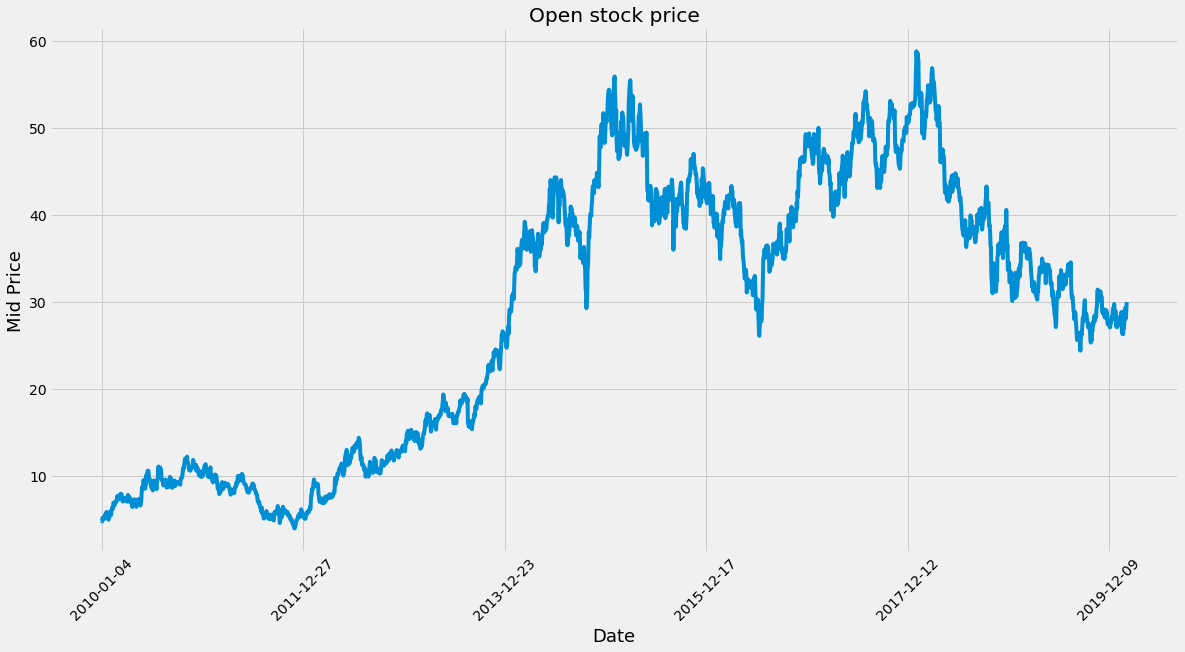

In [67]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df['Open'])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.title('Open stock price')
plt.show()

This graph already says a lot of things.  This graph is bursting with different behaviors of stock prices over time. This will make the learning more robust as well as give you a change to test how good the predictions are for a variety of situations.

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,4.84,4.94,4.66,4.77,4.496876,9837300
1,2010-01-05,4.79,5.37,4.71,5.31,5.005957,25212000
2,2010-01-06,5.19,5.38,5.00,5.09,4.798555,16597900
3,2010-01-07,5.06,5.43,5.05,5.24,4.939965,14033400
4,2010-01-08,5.27,5.43,5.06,5.14,4.845690,12760000


Let's see the yearly mean open for our stock prices :

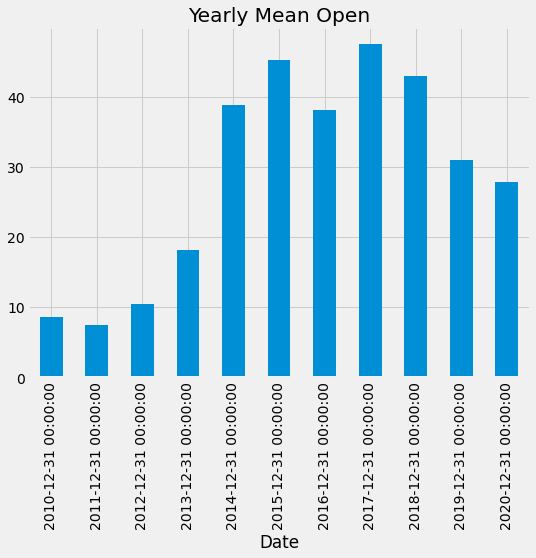

In [76]:
plt.rcParams['figure.figsize'] = (8, 6)
df['Open'].resample('A').mean().plot(kind='bar')
plt.title('Yearly Mean Open');

The above bar plot corresponds to Market prices Open at year-end for each year in our data set.

Below is a complete list of the offset values. 
![](https://cdn-images-1.medium.com/max/800/1*piQRFEDprVNqznejGotpcw.png)

It appears that the Date column is being treated as a string rather than as dates. To fix this, we’ll use the pandas to_datetime() feature which converts the arguments to dates.

In [73]:
# Convert string to datetime64
df['Date'] = df['Date'].apply(pd.to_datetime)
df.set_index('Date',inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,4.84,4.94,4.66,4.77,4.496876,9837300
2010-01-05,4.79,5.37,4.71,5.31,5.005957,25212000
2010-01-06,5.19,5.38,5.00,5.09,4.798555,16597900
2010-01-07,5.06,5.43,5.05,5.24,4.939965,14033400
2010-01-08,5.27,5.43,5.06,5.14,4.845690,12760000


*About the Stock Data*

Now that our data has been converted into the desired format, let’s take a look at its various columns for further analysis.

- The Open and Close columns indicate the opening and closing price of the stocks on a particular day.
- The High and Low columns provide the highest and the lowest price for the stock on a particular day, respectively.
- The Volume column tells us the total volume of stocks traded on a particular day.

Let's further analyse the data for the year 2018.

In [54]:
df_open = df[['Date','Open']]
df_open['Date'] = df_open['Date'].apply(pd.to_datetime)
df_open.set_index("Date", inplace = True)
df_open.head()

,Open
Date,
2010-01-04,4.84
2010-01-05,4.79
2010-01-06,5.19
2010-01-07,5.06
2010-01-08,5.27


In [79]:
# Slicing on year
df_2018 = df_open['2018']

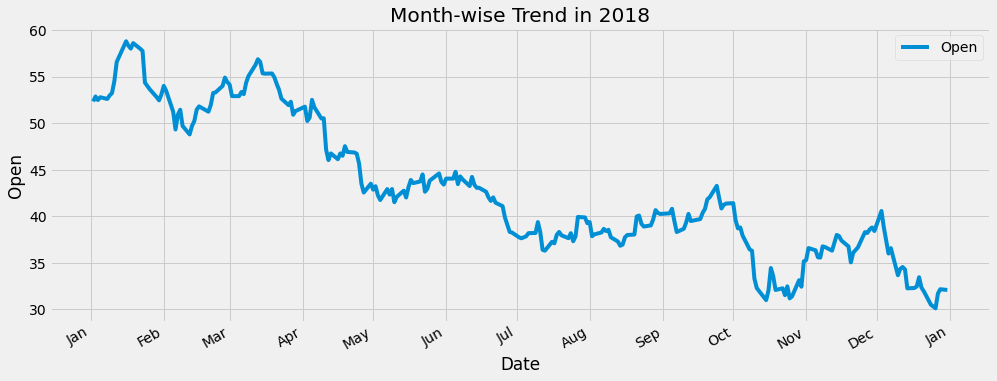

In [81]:
import matplotlib.dates as mdates

ax = df_2018.plot(figsize=(15,6))
ax.set_title('Month-wise Trend in 2018'); 
ax.set_ylabel('Open');
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'));

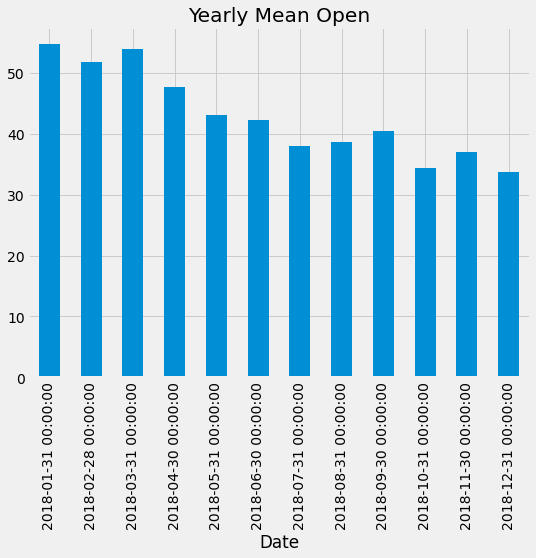

In [82]:
plt.rcParams['figure.figsize'] = (8, 6)
df_2018['Open'].resample('M').mean().plot(kind='bar')
plt.title('Yearly Mean Open');

We see that there was a dip in the stock prices particularly around end of October and November. Let's zoom in on these dates

In [64]:
# Slicing on year
df_oct_nov_2018 = df_open['2018-10':'2018-11']

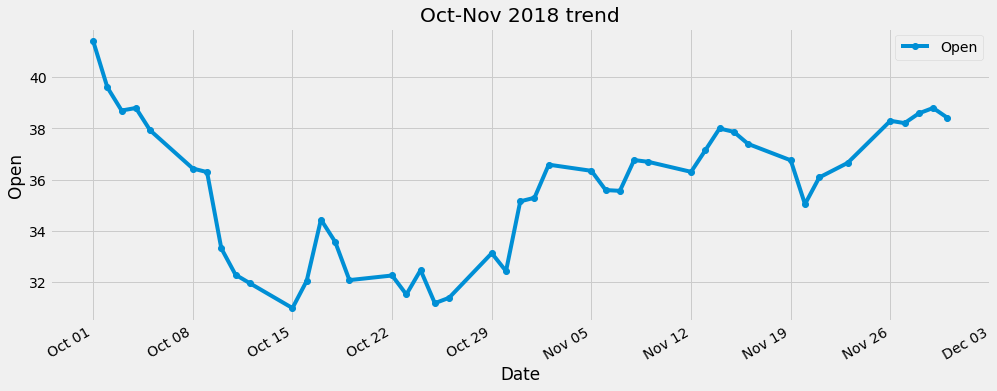

In [69]:
ax = df_oct_nov_2018.plot(marker='o', linestyle='-',figsize=(15,6))
ax.set_title('Oct-Nov 2018 trend'); 
ax.set_ylabel('Open');
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

So there is a dip in stock prices around the last week of october and first week of November. One could investigate it further by finding out if there was some special event that occured on that day.

For now I will use a Support Vector Regression (SVR), Linear Regression and Lasso. Actually those program are really simple but it’s slightly better than guessing! I will try some advanced methods after !

I only need the opening price for the market session (Open), so I am getting data only from the column ‘Open’ and storing this back into the variable ‘df’. Then printing the first 5 rows of the new data set.

In [24]:
# Get the Adjusted Open Price 
df = df[['Open']] 
# Take a look at the new data 
print(df.head())

            Open
Date            
2010-01-04  4.84
2010-01-05  4.79
2010-01-06  5.19
2010-01-07  5.06
2010-01-08  5.27


Now , I’m creating a variable called forecast_out, to store the number of days (30 days) into the future that I want to predict. This variable will be used through out the program so that I can simply change the number and the rest of the program will correspond accordingly. So if I decide I only want to look 20 days into the future, I can simply change this variable from 30 to 20, and the program will predict now 20 days into the future.

In [398]:
# A variable for predicting 'n' days out into the future
forecast_out = 30 #'n=30' days
#Create another column (the target ) shifted 'n' units up
df['Prediction'] = df[['Open']].shift(-forecast_out)
#print the new data set
print(df.tail())

                 Open  Prediction
Date                             
2020-02-06  29.260000         NaN
2020-02-07  28.059999         NaN
2020-02-10  28.190001         NaN
2020-02-11  29.059999         NaN
2020-02-12  30.000000         NaN


Next, I want to create the independent data set (X). This is the data set that I will use to train the machine learning model(s). 

In [399]:
### Create the independent data set (X)  #######
# Convert the dataframe to a numpy array
X = np.array(df.drop(['Prediction'],1))

#Remove the last '30' rows
X = X[:-forecast_out]
print(X)

[[ 4.84]
 [ 4.79]
 [ 5.19]
 ...
 [29.32]
 [29.76]
 [28.5 ]]


now I will create the dependent data set called ‘y’. This is the target data, the one that holds the future price predictions.

In [400]:
### Create the dependent data set (y)
# Convert the dataframe to a numpy array 
y = np.array(df['Prediction'])
# Get all of the y values except the last '30' rows
y = y[:-forecast_out]
print(y)

[ 6.89      6.75      6.65     ... 28.190001 29.059999 30.      ]


Now that I have my new cleaned and processed data sets ‘X’ & ‘y’. I can split them up into 80% training and 20 % testing data for the model(s).

In [401]:
# Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

I can start creating and training the models !

<a id="3"></a> <br>
## Support Vector Machine

In [402]:
# Create and train the Support Vector Machine (Regressor) 
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1) 
svr_rbf.fit(x_train, y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Let’s test the model by getting the score also known as the coefficient of determination R² of the prediction. The best possible score is 1.0, and the model returns a score of ~0,95.

In [374]:
svm_confidence = svr_rbf.score(x_test, y_test)
print("svm confidence: ", svm_confidence)

svm confidence:  0.9503613667931767


<a id="4"></a> <br>
##  Linear Regression

In [377]:
# Create and train the Linear Regression  Model
lr = LinearRegression()
# Train the model
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [380]:
lr_confidence = lr.score(x_test, y_test)
print("lr confidence: ", lr_confidence)

lr confidence:  0.9466959580860157


This time I obtained a R2 slightly worse.

<a id="5"></a> <br>
##  Lasso

In [381]:
lasso = linear_model.Lasso(alpha=0.1).fit(x_train, y_train)

In [382]:
# Testing Model: Score returns the coefficient of determination R^2 of the prediction. 
# The best possible score is 1.0
lasso_confidence = lasso.score(x_test, y_test)
print("lasso confidence: ", lasso_confidence)

lasso confidence:  0.9466960579713387


For now it's seems that SVM is the bast, but let's see other metrics to cehck this out more in depths.

Let's make prediction with our three models and see MSE, RMSE, MAE and MAPE.

Just a reminder :

- MSE is the average squared difference between the estimated values and the actual value. Values closer to zero are better.
- The smaller the RMSE is, the better the model is.
- MAE is an average of the absolute errors
- MAPE measures the size of the error in percentage terms.

<a id="6"></a> <br>
## Machine learning models performance

In [383]:
#SVM
y_train_pred = svr_rbf.predict(x_train)
y_test_pred = svr_rbf.predict(x_test)

#Linear Regression
y_train_pred2 = lr.predict(x_train)
y_test_pred2 = lr.predict(x_test)

#Lasso
y_train_pred3 = lasso.predict(x_train)
y_test_pred3 = lasso.predict(x_test)

Quickly, I build a function for MAPE 

In [404]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [387]:
print("svm confidence: ", svm_confidence)
print("linear regression confidence: ", lr_confidence)
print("lasso confidence: ", lasso_confidence)
print()
print()
print('R^2   train for SVM: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('R^2   train for Linear Regression: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred2),
                                       r2_score(y_test, y_test_pred2)))

print('R^2   train for Lasso: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred3),
                                       r2_score(y_test, y_test_pred3)))

svm confidence:  0.9503613667931767
linear regression confidence:  0.9466959580860157
lasso confidence:  0.9466960579713387


R^2   train for SVM: 0.95, test: 0.95
R^2   train for Linear Regression: 0.94, test: 0.95
R^2   train for Lasso: 0.94, test: 0.95


SVM seems slightly better for R2 metrics, like we already said.

In [388]:
print('MSE   train for SVM: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('MSE   train for Linear regression: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred2),
       mean_squared_error(y_test, y_test_pred2)))

print('MSE   train for Lasso: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred3),
       mean_squared_error(y_test, y_test_pred3)))

MSE   train for SVM: 12.89, test: 12.41
MSE   train for Linear regression: 15.05, test: 13.33
MSE   train for Lasso: 15.05, test: 13.33


SVM, again, seems to perform better. Moreover, SVM seems the less inclined to overfit. The MSE test is close to the MSE train.

In [389]:

print('RMSE  train SVM: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('RMSE  train Linear Regression: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred2)),
       np.sqrt(mean_squared_error(y_test, y_test_pred2))))

print('RMSE  train Lasso: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred3)),
       np.sqrt(mean_squared_error(y_test, y_test_pred3))))

RMSE  train SVM: 3.59, test: 3.52
RMSE  train Linear Regression: 3.88, test: 3.65
RMSE  train Lasso: 3.88, test: 3.65


Again, SVM is slightly better.

In [390]:
print('MAE   train SVM: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAE   train Linear Regression: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred2),
       mean_absolute_error(y_test, y_test_pred2)))

print('MAE   train Lasso: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred3),
       mean_absolute_error(y_test, y_test_pred3)))

MAE   train SVM: 2.61, test: 2.63
MAE   train Linear Regression: 2.94, test: 2.78
MAE   train Lasso: 2.94, test: 2.78


SVM did better.

In [391]:

print('MAPE  train SVM: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

print('MAPE  train Linear regression: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred2),
       mean_absolute_percentage_error(y_test, y_test_pred2)))

print('MAPE  train Lasso: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred3),
       mean_absolute_percentage_error(y_test, y_test_pred3)))

MAPE  train SVM: 10.44, test: 10.39
MAPE  train Linear regression: 12.25, test: 11.63
MAPE  train Lasso: 12.26, test: 11.64


It looks like in this case the SVL model will be better to use to predict the future opening price for the market session, because it had the best metrics among others.

Now I will do some forecasting / predictions. I will take the last 30 rows of data from the data frame of the Open price, and store it into a variable called x_forecast.

In [405]:
# Set x_forecast equal to the last 30 rows of the original data set from Adj. Close column
x_forecast = np.array(df.drop(['Prediction'],1))[-forecast_out:]
print(x_forecast)

[[28.200001]
 [28.98    ]
 [28.27    ]
 [27.190001]
 [27.559999]
 [27.1     ]
 [28.09    ]
 [27.959999]
 [27.32    ]
 [27.91    ]
 [27.450001]
 [27.790001]
 [28.299999]
 [27.969999]
 [27.51    ]
 [27.389999]
 [28.85    ]
 [26.57    ]
 [26.360001]
 [26.879999]
 [26.299999]
 [27.5     ]
 [26.93    ]
 [27.68    ]
 [28.959999]
 [29.26    ]
 [28.059999]
 [28.190001]
 [29.059999]
 [30.      ]]


In [406]:
# Print linear regression model predictions for the next '30' days
SVM_prediction = svr_rbf.predict(x_forecast)
print(SVM_prediction)
print()

[28.4127969  29.24762928 28.40061381 29.69487577 29.10048699 29.82699258
 28.46296301 28.56644505 29.4904083  28.61752078 29.27836842 28.76173805
 28.40034547 28.5569375  29.18072384 29.37654488 28.96114313 30.30421229
 30.30202367 30.09809792 30.27935115 29.19691869 30.04421883 28.9157921
 29.20008794 30.02750363 28.48281833 28.4158251  29.44958882 32.53701884]



<a id="7"></a> <br>
## One-Step Ahead Prediction via Averaging

This time I will try two methods found on internet :

- standard averaging 
- exponential moving average

Averaging mechanisms allow you to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results.

I will evaluate both qualitatively (visual inspection) and quantitatively (Mean Squared Error) the results produced by the two algorithms.

I wanted to predict another variable this time, to try something different. I will use the mid price calculated by taking the average of the highest and lowest recorded prices on a day.

### Data Preprocessing

In [413]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
mid_prices = (high_prices+low_prices)/2.0

mid_prices = pd.DataFrame(mid_prices)

train_data = mid_prices[:2000]
test_data = mid_prices[2000:]

### Normalizing the Data

I need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1.

In [414]:
scaler = MinMaxScaler()
train_data = train_data.values.reshape(-1,1)
test_data = test_data.values.reshape(-1,1)

In [415]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 1200
for di in range(0,2000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

In [416]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [417]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

<a id="8"></a> <br>
## Standard Average

In [418]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00580


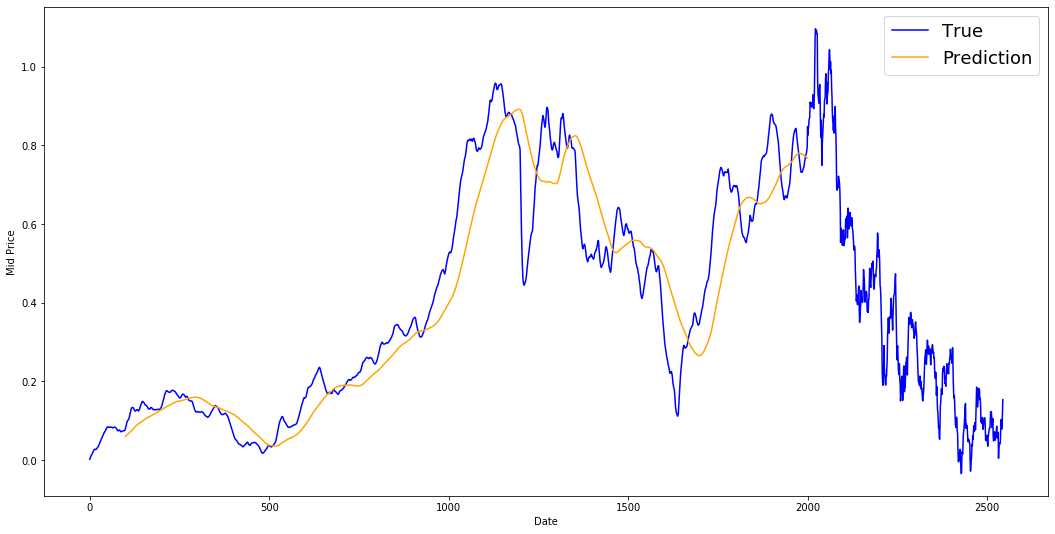

In [419]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

So what do the above graphs (and the MSE) say?

It seems that it is quite good for a model with very short predictions (one day ahead). I assume that stock prices don't change from 0 to 100 overnight, this behavior is sensible.

Now I will look at a more accurate one-step prediction method known as exponential moving average.

<a id="9"></a> <br>
## Exponential moving average

In [421]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00005


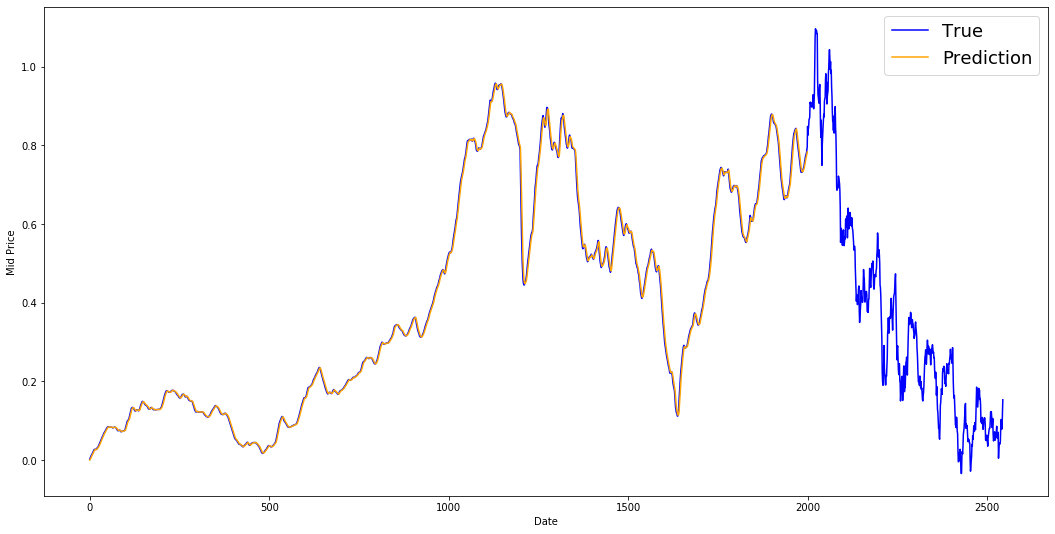

In [422]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Exponential Moving Average is really good but jsut in short-term, if we want to predict in the next 30 days for example, we will see the incapability of the EMA method. 

Now, I will use a more complex model : an LSTM model.

It seems that these models have taken the realm of time series prediction by storm, because they are so good at modelling time series data. Apparently Long Short-Term Memory models are extremely powerful time-series models.

<a id="10"></a> <br>
## Deep Learning with LSTM 

First I will forecast a univariate time series (with only Open) then I will forecast a multivariate time series (with dummy on Date).

In [63]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

The function below returns the above described windows of time for the model to train on. The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

In [64]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

The first 2000 rows of the data will be the training dataset, and there remaining will be the validation dataset.

In [65]:
TRAIN_SPLIT = 2000

In [66]:
#Setting seed to ensure reproducibility
tf.random.set_seed(13)

<a id="11"></a> <br>
##  Univariate time series with LSTM

##### One step ahead

Like I said, I will train a model using only a single feature (Open), and use it to make predictions for that value in the future.

In [423]:
df = pd.read_csv('df.csv')

In [424]:
uni_data = df['Open']
uni_data.index = df['Date']
uni_data.head()

Date
2010-01-04    4.84
2010-01-05    4.79
2010-01-06    5.19
2010-01-07    5.06
2010-01-08    5.27
Name: Open, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E46012A3C8>],
      dtype=object)

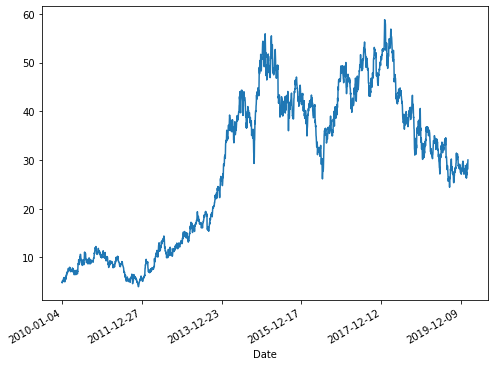

In [57]:
uni_data.plot(subplots=True)

In [425]:
uni_data = uni_data.values

It is important to scale features before training a neural network. Earlier I used Normalisation, this time I will use Standardization instead. It's a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.

In [426]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [427]:
uni_data = (uni_data-uni_train_mean)/uni_train_std #standardize insteand of normalize

Let's now create the data for the univariate model. The model will be given the last 50 recorded Open observations, and needs to learn to predict the temperature at the next time step.

In [448]:
univariate_past_history = 50
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [450]:
def create_time_steps(length):
  return list(range(-length, 0))

In [451]:

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

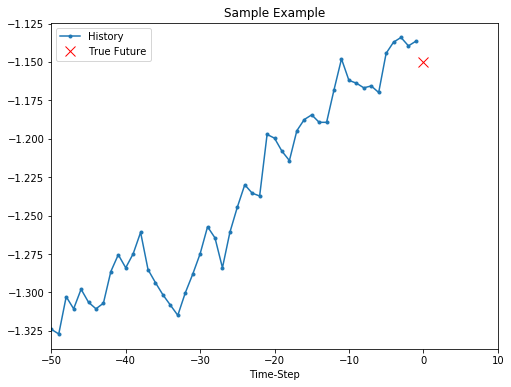

In [452]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. I will use a specialized RNN layer called Long Short Term Memory (LSTM)

Let's now use tf.data to shuffle, batch, and cache the dataset.

In [453]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [454]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [455]:
LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae', 'mape'])

Let's now train the model

In [456]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

history = LSTM_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2806 - mse: 0.1718 - mae: 0.2812 - mape: 38.5988 - val_loss: 0.1054 - val_mse: 0.0182 - val_mae: 0.1057 - val_mape: 91.8715
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0628 - mse: 0.0074 - mae: 0.0628 - mape: 14.0204 - val_loss: 0.0700 - val_mse: 0.0082 - val_mae: 0.0703 - val_mape: 96.1978
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0533 - mse: 0.0055 - mae: 0.0533 - mape: 12.9581 - val_loss: 0.0582 - val_mse: 0.0058 - val_mae: 0.0584 - val_mape: 141.1705
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0472 - mse: 0.0044 - mae: 0.0472 - mape: 12.0973 - val_loss: 0.0533 - val_mse: 0.0049 - val_mae: 0.0535 - val_mape: 136.8888
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0425 - mse: 0.0037 - mae: 0.0426 - mape: 10.9943 - val_loss: 0.0492 - val_

And let's see if he performs well

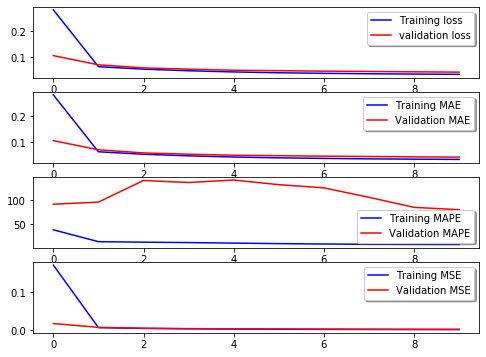

In [457]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(4,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mae'], color='b', label="Training MAE")
ax[1].plot(history.history['val_mae'], color='r',label="Validation MAE")
legend = ax[1].legend(loc='best', shadow=True)

ax[2].plot(history.history['mape'], color='b', label="Training MAPE")
ax[2].plot(history.history['val_mape'], color='r',label="Validation MAPE")
legend = ax[2].legend(loc='best', shadow=True)

ax[3].plot(history.history['mse'], color='b', label="Training MSE")
ax[3].plot(history.history['val_mse'], color='r',label="Validation MSE")
legend = ax[3].legend(loc='best', shadow=True)

It seems to perform nicely !

Let's make a few predictions.

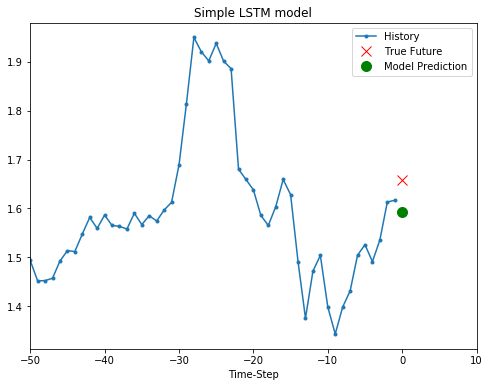

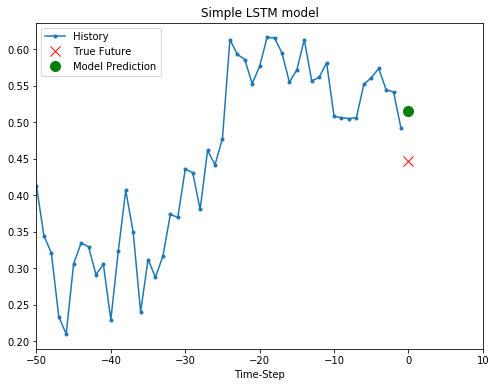

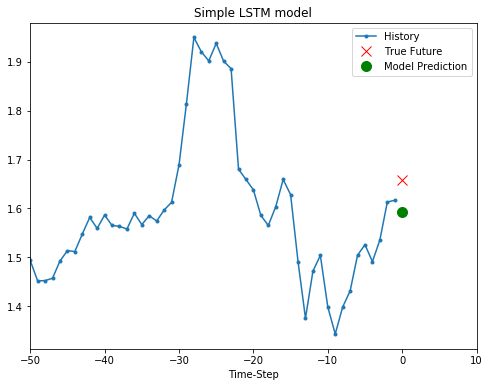

In [458]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

That's close ! Great but it's only one steps. Let's try multi steps. 
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

That's the real big deal !

#####  Multi step ahead

In [486]:
df = pd.read_csv('df.csv')

In [487]:
features_considered = ['Open']

In [488]:
features = df[features_considered]
features.index = df['Date']
features.head()

,Open
Date,
2010-01-04,4.84
2010-01-05,4.79
2010-01-06,5.19
2010-01-07,5.06
2010-01-08,5.27


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000239FE7068D0>],
      dtype=object)

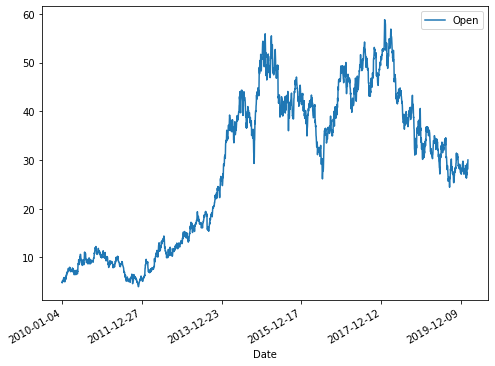

In [489]:
features.plot(subplots=True)

In [490]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [491]:
dataset = (dataset-data_mean)/data_std

In [492]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

Here, I will try to predict 40 day ahead, it's huge but let's try !

In [493]:
past_history = 50
future_target = 40
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)


In [494]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

Let's see our real values

In [224]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every day.

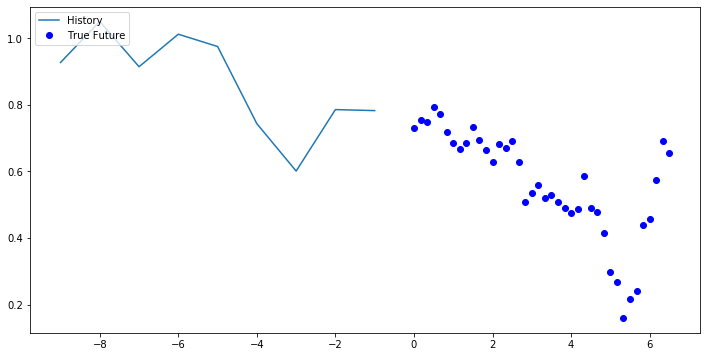

In [225]:
for x, y in train_data_single.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 40 predictions are made, the dense layer outputs 40 predictions.

In [495]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dense(40))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae', metrics=['mse', 'mae'])

In [496]:
history = multi_step_history = multi_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1672 - mse: 0.0621 - mae: 0.1677 - val_loss: 0.2013 - val_mse: 0.0595 - val_mae: 0.2011
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1216 - mse: 0.0267 - mae: 0.1218 - val_loss: 0.1709 - val_mse: 0.0479 - val_mae: 0.1711
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1146 - mse: 0.0232 - mae: 0.1144 - val_loss: 0.1726 - val_mse: 0.0484 - val_mae: 0.1728
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1108 - mse: 0.0220 - mae: 0.1108 - val_loss: 0.1625 - val_mse: 0.0423 - val_mae: 0.1627
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1090 - mse: 0.0215 - mae: 0.1091 - val_loss: 0.1708 - val_mse: 0.0463 - val_mae: 0.1709
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1084 - mse: 0.0213 - mae: 0.1083 - val_loss: 0.1608 - val_ms

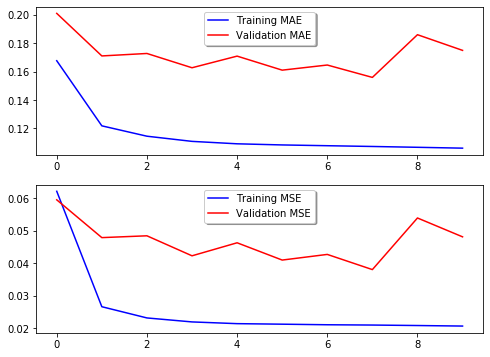

In [498]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)

ax[0].plot(history.history['mae'], color='b', label="Training MAE")
ax[0].plot(history.history['val_mae'], color='r',label="Validation MAE")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mse'], color='b', label="Training MSE")
ax[1].plot(history.history['val_mse'], color='r',label="Validation MSE")
legend = ax[1].legend(loc='best', shadow=True)

The MSE and MARE are low, that's great, we need to watch out for overfitting though.

Let's now have a look at how well your network has learnt to predict the future multi step ahead.

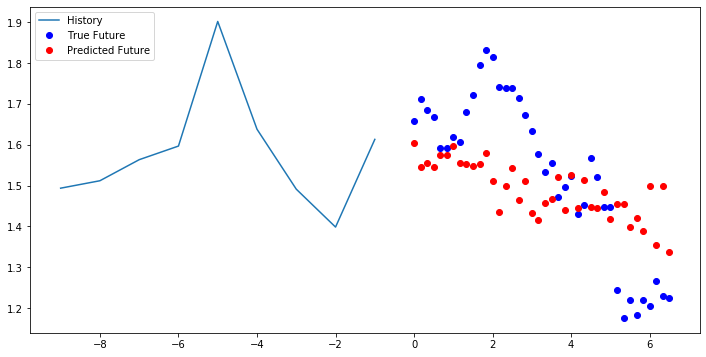

In [229]:
for x, y in val_data_single.take(1):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

The predictions seems to have captured the decreasing trend but not as much as he tend to be. Not bad.

Let's try with multivariate now.

<a id="12"></a> <br>
## Multivariate time series with LSTM

In [534]:
df = pd.read_csv('df.csv', sep = ',', parse_dates= ['Date'],encoding='utf-8-sig') 

First of all, let's create some variable who will indicate the day of week, the month, the year, the day of year, the day and the week of year and after we will make dummy with them.

In [535]:
df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['quarter'] = df['Date'].dt.quarter
df['year'] = df['Date'].dt.year
df['dayofyear'] = df['Date'].dt.dayofyear
df['dayofmonth'] = df['Date'].dt.day
df['weekofyear'] = df['Date'].dt.weekofyear

X = df[['dayofweek','month', 'quarter', 'year', 'dayofyear','dayofmonth', 'weekofyear']]

In [536]:
X.head()

,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear
0,0,1,1,2010,4,4,1
1,1,1,1,2010,5,5,1
2,2,1,1,2010,6,6,1
3,3,1,1,2010,7,7,1
4,4,1,1,2010,8,8,1


In [537]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2545 entries, 0 to 2544
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   dayofweek   2545 non-null   int64
 1   month       2545 non-null   int64
 2   quarter     2545 non-null   int64
 3   year        2545 non-null   int64
 4   dayofyear   2545 non-null   int64
 5   dayofmonth  2545 non-null   int64
 6   weekofyear  2545 non-null   int64
dtypes: int64(7)
memory usage: 139.3 KB


In [538]:
from sklearn.preprocessing import OneHotEncoder

So let's make dummy with our time variables.

In [539]:
one = OneHotEncoder(sparse = False)
one.fit(X)
train = one.transform(X)
print('train data set has got {} rows and {} columns'.format(train.shape[0],train.shape[1]))

train data set has got 2545 rows and 481 columns


We can see we have now 481 columns

In [540]:
train = pd.DataFrame(train)
w = df['Open']
w = pd.DataFrame(w)
train.index = df['Date']
w.index = df['Date']
df_merged = w.merge(train, how='outer', left_index=True, right_index=True)

As usual, let's normalize the data

In [334]:
dataset = df_merged.values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

We will try to predict 20 days ahead

In [344]:
future_target = 20
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [346]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

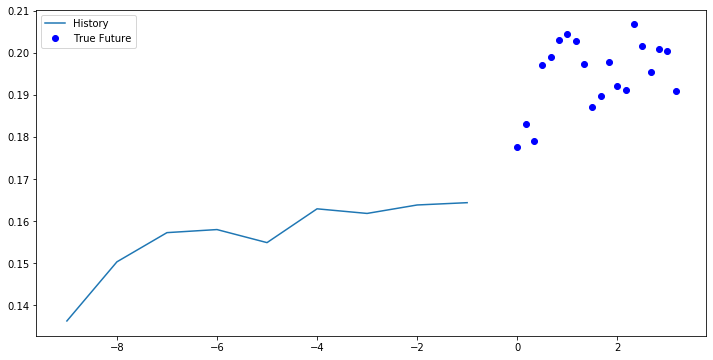

In [347]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Let's build our new model.

In [360]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(20))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mse'])

In [361]:
history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 128 steps, validate for 50 steps
Epoch 1/10
128/128 [==============================] - 11s 82ms/step - loss: 0.1136 - mse: 0.0410 - val_loss: 0.1761 - val_mse: 0.0421
Epoch 2/10
128/128 [==============================] - 6s 48ms/step - loss: 0.0422 - mse: 0.0032 - val_loss: 0.1598 - val_mse: 0.0360
Epoch 3/10
128/128 [==============================] - 7s 52ms/step - loss: 0.0362 - mse: 0.0024 - val_loss: 0.1408 - val_mse: 0.0292
Epoch 4/10
128/128 [==============================] - 6s 46ms/step - loss: 0.0325 - mse: 0.0020 - val_loss: 0.1281 - val_mse: 0.0251
Epoch 5/10
128/128 [==============================] - 6s 46ms/step - loss: 0.0300 - mse: 0.0017 - val_loss: 0.1182 - val_mse: 0.0218
Epoch 6/10
128/128 [==============================] - 7s 52ms/step - loss: 0.0280 - mse: 0.0015 - val_loss: 0.1112 - val_mse: 0.0194
Epoch 7/10
128/128 [==============================] - 6s 51ms/step - loss: 0.0264 - mse: 0.0013 - val_loss: 0.1066 - val_mse: 0.0182
Epoch 8/10
128/128 [=====

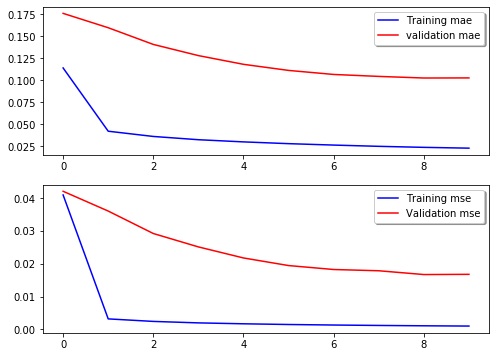

In [363]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training mae")
ax[0].plot(history.history['val_loss'], color='r', label="validation mae",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mse'], color='b', label="Training mse")
ax[1].plot(history.history['val_mse'], color='r',label="Validation mse")
legend = ax[1].legend(loc='best', shadow=True)

Not bad at all, even if I think this model will overfit. Let's make some predictions multi steps ahead.

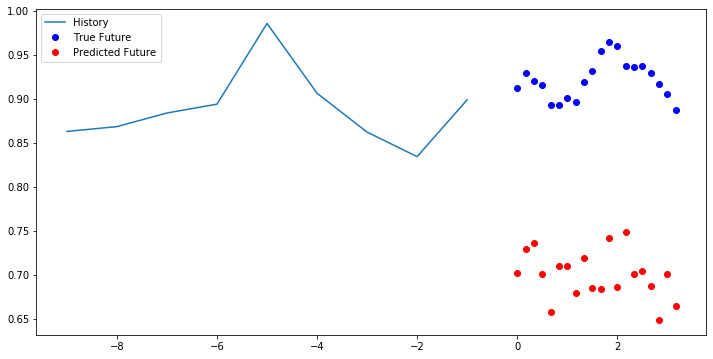

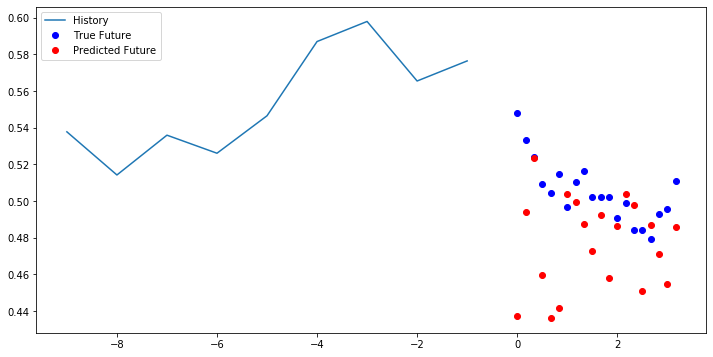

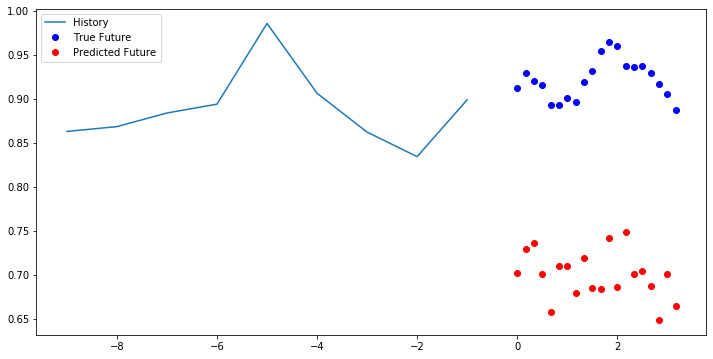

In [364]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

It seems that my model tend to underestimate the true future, but stay relatively close.

To conclude, all of my models seems to perofrm well but I remain realistic, it's also posibble that they tend to be overfitting. We shall see.


Let us not forgot that Stock market prices are highly unpredictable and volatile. This means that there are no consistent patterns in the data that allow you to model stock prices over time near-perfectly. 

I've seen on internet some people mention that  stock (and other) prices are unforecastable, because if there were some way of forecasting them, people would use that forecast to go short or long, instantaneously driving the price to the "true" value.